In [1]:
import pandas as pd
import re

import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

#nltk stopwords
from nltk.corpus import stopwords

# Plotting tools
import matplotlib.pyplot as plt

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### Read Posts

In [2]:
name = "LatinosForBiden"
terms = "biden|democratas|democrata"
candidate = pd.read_csv(name+".csv")
candidate.shape

FileNotFoundError: [Errno 2] No such file or directory: 'LatinosForBiden.csv'

In [136]:
candidate.columns

Index(['Group Name', 'User Name', 'Facebook Id', 'Likes at Posting', 'Created',
       'Type', 'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad',
       'Angry', 'Care', 'Video Share Status', 'Post Views', 'Total Views',
       'Total Views For All Crossposts', 'Video Length', 'URL', 'Message',
       'Link', 'Final Link', 'Image Text', 'Link Text', 'Description',
       'Sponsor Id', 'Sponsor Name', 'Total Interactions',
       'Total Interactions (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )'],
      dtype='object')

## Filter the most relevant columns

In [137]:
content = candidate[['Message','Description','Link','Group Name','Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad',
       'Angry', 'Care','Total Interactions']].copy()
content.shape

(4971, 14)

### Add column to concat Message and Description

In [138]:
concat_message = content['Message'].fillna('') + (' ' + content['Description']).fillna('')
content['MessageDescr'] = concat_message

### Just keep those groups that have Trump or Republican in their name

In [139]:
groups_candidate = content['Group Name'].str.lower().reset_index()
final_groups = groups_candidate[groups_candidate['Group Name'].str.contains(terms)].copy()
final_groups = final_groups['Group Name'].unique()
final_groups = pd.DataFrame(final_groups)
final_groups.columns = ['Group Name']
final_groups.to_csv(name+"_ThePostgroups.csv")
final_groups.shape

(111, 1)

In [140]:
content['Group Name'] = content['Group Name'].str.lower()
content.shape

(4971, 15)

### Keep the posts from the preselected groups

In [141]:
content = content[content['Group Name'].isin(final_groups['Group Name'])].copy()
content.shape

(477, 15)

## Tokenize words and Clean-up text

In [92]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(477,)

In [93]:
# Convert to list
data = content.cleanMessage.tolist()

In [94]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [95]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['ricky', 'martin', 'one', 'of', 'the', 'biggest', 'hispanic', 'pop', 'icon', 'openly', 'supporting', 'joe', 'biden', 'pleads', 'for', 'all', 'his', 'followers', 'to', 'support', 'joe', 'biden', 'for', 'presdident', 'el', 'artista', 'que', 'ha', 'expresado', 'en', 'mas', 'de', 'una', 'ocasion', 'su', 'contrariedad', 'la', 'politica', 'de', 'trump', 'participa', 'en', 'un', 'encuentro', 'del', 'candidato', 'democrata', 'con', 'los', 'latinos', 'luis', 'fonsi', 'eva', 'longoria', 'tambien', 'pidieron', 'su', 'voto', 'en', 'dicho', 'evento']]


#### Creating Bigram and Trigram Models

In [96]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['ricky_martin', 'one', 'of', 'the', 'biggest', 'hispanic', 'pop', 'icon', 'openly', 'supporting', 'joe', 'biden', 'pleads', 'for', 'all', 'his', 'followers', 'to', 'support', 'joe', 'biden', 'for', 'presdident', 'el', 'artista', 'que', 'ha', 'expresado', 'en', 'mas', 'de', 'una', 'ocasion', 'su', 'contrariedad', 'la', 'politica', 'de', 'trump', 'participa', 'en', 'un', 'encuentro', 'del', 'candidato', 'democrata', 'con', 'los', 'latinos', 'luis', 'fonsi', 'eva_longoria', 'tambien', 'pidieron', 'su', 'voto', 'en', 'dicho', 'evento']


In [97]:
stop_words = stopwords.words('english')
stop_words.extend(stopwords.words('spanish'))
stop_words.extend(['su','sus','al','de','en','el'])
stop_words.extend(['like','would','get','many','much'])

## Remove Stopwords, Make Bigrams and Lemmatize

In [98]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts,stop_words_lang):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words_lang] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

## Bag of Words

In [99]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words,stop_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#!python3 -m spacy download en
nlp = spacy.load('es', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

[['openly', 'pleads', 'artista', 'expresar', 'politica', 'trump', 'participar', 'encontrar', 'candidato', 'tambien', 'pedir', 'votar', 'decir', 'evento'], ['needed', 'sanity']]


In [100]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        print(concat_name, dictionary[concat_name])
    return dictionary

In [101]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [102]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)

In [103]:
final_dict.most_common(1000)

[('trump', 356),
 ('votar', 106),
 ('latino', 79),
 ('virus', 69),
 ('debatir', 54),
 ('america', 45),
 ('also', 44),
 ('coronavirus', 43),
 ('democrats', 37),
 ('campaign', 35),
 ('didnt', 30),
 ('lives', 29),
 ('political', 26),
 ('everyone', 26),
 ('president', 25),
 ('country', 25),
 ('race', 24),
 ('copy', 24),
 ('states', 23),
 ('pandemic', 23),
 ('people', 22),
 ('national', 21),
 ('join', 21),
 ('efforts', 20),
 ('preguntar', 20),
 ('deaths', 19),
 ('choose', 19),
 ('timar', 18),
 ('repeal', 18),
 ('discussed', 17),
 ('responsar', 15),
 ('college', 15),
 ('placer', 15),
 ('especially', 14),
 ('crisis', 14),
 ('noviembre', 14),
 ('losar', 14),
 ('vulnerable', 13),
 ('mayor', 13),
 ('able', 13),
 ('crucial', 13),
 ('racial', 13),
 ('florido', 13),
 ('look', 12),
 ('electoral', 12),
 ('decidir', 12),
 ('possible', 12),
 ('presidential', 12),
 ('really', 12),
 ('nuevo', 12),
 ('senator', 12),
 ('local', 12),
 ('septiembre', 12),
 ('rioting', 12),
 ('corona_virus', 12),
 ('touching_

## TD-IDF

In [104]:
docs = ([' '.join(ele) for ele in data_words_nostops] )

In [105]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
word_count_vector.shape

(477, 5673)

In [106]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [107]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
biden,1.221576
latinos,1.232075
joe,1.766933
trump,1.846601
vote,2.165664
...,...
identify,6.476464
ideologies,6.476464
ideology,6.476464
hurting,6.476464


In [108]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [109]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False).to_csv(name+"_tfidf.csv")

In [110]:
df

,tfidf
artista,0.194876
biden,0.078424
biggest,0.153169
candidato,0.167678
contrariedad,0.194876
democrata,0.194876
dicho,0.194876
encuentro,0.194876
eva,0.172626
evento,0.172626


In [111]:
word = df.index[0]
content["lowercase"] = content['MessageDescr'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]

word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')
word_messages.to_csv(word +"_"+ name+"_messages.csv")
word_messages

,unique_messages,counts
0,ricky martin one of the biggest hispanic pop i...,2
1,for all latinos in miami who support biden... ...,1
2,https://www.youtube.com/watch?v=i2ynxayspew es...,1


### Repeated messages

In [130]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr','Link']).aggregate({'Group Name':'count','Group Name':' | '.join,'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum','Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})

results.rename(columns={"MessageDescr": "Counts",'Group Name':"Groups"}, inplace=True)


results.to_csv("LatinosForBidenThePost"+name+".csv")

In [131]:
#results.sort_values(by='Counts',ascending=False)
results

Groups  \
MessageDescr                                       Link                                                                                                    
 "Joe Biden is a puppet of the extreme left who... https://www.facebook.com/LatinosForTrump/videos...                                  ridin' with biden   
 "Voter turnout among Latinos in Florida could ... http://hill.cm/RYzMkKl                                                              cubanos con biden   
 #TodosConBiden                                    https://www.facebook.com/LatinosConBiden/photos...                                  cubanos con biden   
 (CNN)Former President Barack Obama delivered a... https://www.cnn.com/videos/politics/2020/10/21/...  why i love joe biden-kamala harris / why i hat...   
 30,000 vehicles showed for a 'Latinos for Trum... https://www.lawenforcementtoday.com/30000-vehic...  blacks who justify joe biden lying to black am...   
...                                                                                                                                                  ...   
🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸 A new poll finds that Latino voter... https://bit.ly/2G7cGUv                                                          joe biden for florida   
👏🏻👏🏻👏🏻💙💙💙LATINOS FOR BIDEN 🇺🇸🇺🇸👊🏻👊🏻🇺🇸🇵🇷🇨🇺🇨🇴🇪🇨🇦🇷... https://www.facebook.com/groups/CubanosConBiden...                                  cubanos con biden   
💙 Official Webstore of Biden for President         https://store.joebiden.com/latinos-for-biden-wh...                             joe biden for colorado   
📍Miami-Dade, FL #TodosConBidenCaravan 📍Miami-Da... https://www.facebook.com/FLDemocratsForOffice/p...  biden for florida | joe biden for florida | cu...   
😂😆 Why do some people vote against their own in... https://www.facebook.com/ridinwithbiden2020/pho...                                  biden/harris 2020   

                                                                                                       Counts  \
MessageDescr                                       Link                                                         
 "Joe Biden is a puppet of the extreme left who... https://www.facebook.com/LatinosForTrump/videos...       1   
 "Voter turnout among Latinos in Florida could ... http://hill.cm/RYzMkKl                                   1   
 #TodosConBiden                                    https://www.facebook.com/LatinosConBiden/photos...       1   
 (CNN)Former President Barack Obama delivered a... https://www.cnn.com/videos/politics/2020/10/21/...       1   
 30,000 vehicles showed for a 'Latinos for Trum... https://www.lawenforcementtoday.com/30000-vehic...       1   
...                                                                                                       ...   
🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸 A new poll finds that Latino voter... https://bit.ly/2G7cGUv                                   1   
👏🏻👏🏻👏🏻💙💙💙LATINOS FOR BIDEN 🇺🇸🇺🇸👊🏻👊🏻🇺🇸🇵🇷🇨🇺🇨🇴🇪🇨🇦🇷... https://www.facebook.com/groups/CubanosConBiden...       1   
💙 Official Webstore of Biden for President         https://store.joebiden.com/latinos-for-biden-wh...       1   
📍Miami-Dade, FL #TodosConBidenCaravan 📍Miami-Da... https://www.facebook.com/FLDemocratsForOffice/p...       6   
😂😆 Why do some people vote against their own in... https://www.facebook.com/ridinwithbiden2020/pho...       1   

                                                                                                       Likes  \
MessageDescr                                       Link                                                        
 "Joe Biden is a puppet of the extreme left who... https://www.facebook.com/LatinosForTrump/videos...      0   
 "Voter turnout among Latinos in Florida could ... http://hill.cm/RYzMkKl                                  9   
 #TodosConBiden                                    https://www.facebook.com/LatinosConBiden/photos...     11   
 (CNN)Former President Barack Obama delivered a... https://www.cnn.com/videos/politics/

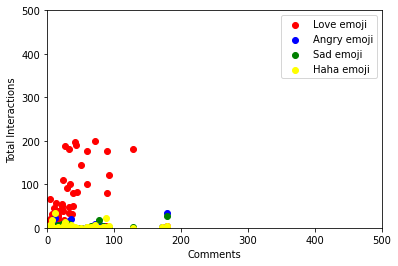

In [132]:
results.reset_index()
plt.xlim(0,500)
plt.ylim(0,500)

plt.xlabel('Comments')
plt.ylabel('Total Interactions')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')
plt.scatter(results.Comments, results.Haha,c='yellow',label='Haha emoji')
plt.legend()